# Inverse fit: adaptive bin refinement

Same setup as the zoom-fit notebook, but using **adaptive bins** (`fit_with_adaptive_bins`): start from a coarse binning, fit, then split only the bins with the largest residuals and refit until a stopping criterion is met.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import permeation as pm

import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = (6, 4)

## 1. Define base parameters and "true" G(t) steps

In [2]:
base_params = pm.Parameters()
base_params.ks = 3.3e19
base_params.kd = 1.2e-34
base_params.D = 1e-8

tstart = [0.0, 0.2, 0.4, 0.5]
true_vals = np.array([0.3, 0.7, 0.6, 0.0])

t_true, pdp_true, G_true = pm.simulate_from_step_vals(true_vals, tstart, base_params)

## 2. Synthetic measurements

In [3]:
rng = np.random.default_rng(0)
t_meas = t_true.copy()
noise = 0.02 * np.max(pdp_true) * rng.normal(size=pdp_true.shape)
pdp_meas = pdp_true + noise

## 3. Adaptive bin fit

Start with one bin over [0, 1]. Each refinement step fits, scores residuals per bin, then splits the worst bins (up to `max_splits`). Stops when no bins are eligible to split, bin count reaches `max_bins`, or `max_refinement_depth` is reached.

In [4]:
edges_frac_0 = np.array([0.0, 1.0])
x0_0 = np.array([0.5])

adaptive = pm.fit_with_adaptive_bins(
    t_meas=t_meas,
    pdp_meas=pdp_meas,
    edges_frac=edges_frac_0,
    x0=x0_0,
    base_params=base_params,
    max_bins=32,
    max_refinement_depth=20,
    max_splits=2,
    min_width_frac=0.02,
    bounds=(0.0, 2.0),
    reg_l2=1e-6,
    reg_tv=1e-3,
    G_zero_after=0.5,
    verbose=1,
    max_nfev=200,
)

print("Refinement iterations:", len(adaptive["history"]))
print("Final bins:", len(adaptive["x_hat"]))
print("Final cost:", adaptive["result"]["result"].cost)

`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 7.1135e+36, final cost 6.9827e+36, first-order optimality 1.08e+34.
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 6.9827e+36, final cost 6.9827e+36, first-order optimality 1.59e+34.
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 28, initial cost 6.9827e+36, final cost 1.3210e+36, first-order optimality 6.65e+33.
`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 1.3210e+36, final cost 5.5662e+35, first-order optimality 2.76e+33.
`ftol` termination condition is satisfied.
Function evaluations 189, initial cost 5.5662e+35, final cost 5.0312e+35, first-order optimality 3.34e+33.
`ftol` termination condition is satisfied.
Function evaluations 179, initial cost 5.0312e+35, final cost 5.0180e+35, first-order optimality 2.97e+33.
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 5.0180e+

## 4. Plot: measured vs fitted pdp, and recovered G(t)

History entries are (edges_frac, x_hat, scores). We simulate from each to get curves for plotting.

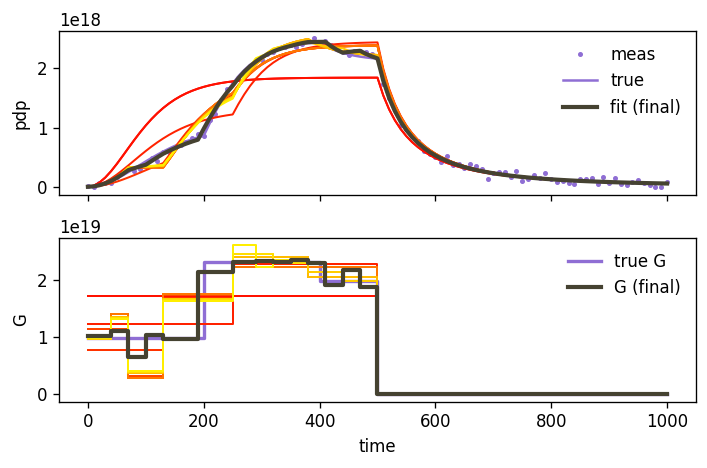

In [5]:
import matplotlib.colors as mcolors

hist = adaptive["history"]
fit = adaptive["result"]
curves = []
for edges, x, _ in hist:
    t_mod, pdp_mod, G_mod = pm.simulate_from_step_vals(
        x, edges[:-1], base_params, enforce_zero_after=0.5
    )
    curves.append({"t_model": t_mod, "pdp_hat": pdp_mod, "G_hat": G_mod})

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t_meas, pdp_meas, "o", color="#8f6ed4", ms=2, label="meas")
ax1.plot(t_true, pdp_true, "-", color="#8f6ed4", label="true")
ax2.step(t_true, G_true, where="post", lw=2, color="#8f6ed4", label="true G")

n_hist = len(curves)
cmap = plt.get_cmap("autumn")
norm = mcolors.Normalize(vmin=0, vmax=max(n_hist - 1, 1))
for k, c in enumerate(curves):
    color = cmap(norm(k))
    ax1.plot(c["t_model"], c["pdp_hat"], "-", lw=1.2, color=color)
    ax2.step(c["t_model"], c["G_hat"], where="post", lw=1.2, color=color)

ax1.plot(fit["t_model"], fit["pdp_hat"], "-", lw=2.5, color="#454231", label="fit (final)")
ax2.step(fit["t_model"], fit["G_hat"], where="post", lw=2.5, color="#454231", label="G (final)")
ax1.set_ylabel("pdp")
ax1.legend(frameon=False)
ax2.set_ylabel("G")
ax2.set_xlabel("time")
ax2.legend(frameon=False)
plt.tight_layout()
plt.show()